In [144]:
import sys, os
import pandas as pd
%matplotlib inline

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
import datetime

DATE = lambda: datetime.datetime.now().strftime("[%m/%d/%Y %H:%M:%S]")


def tune_elasticnet(X_train_, y_train_, rand_seed_, log_grid_, n_core=6):
    """tune elasticnet model one round"""
    log_estimator = LogisticRegression(solver='saga',
                                       penalty='elasticnet',
                                       random_state=rand_seed_)

    log_model = GridSearchCV(estimator=log_estimator,
                             param_grid=log_grid_,
                             verbose=0,
                             n_jobs=n_core,
                             cv=3,
                             scoring='accuracy')

    log_model.fit(X_train_, np.ravel(y_train_))

    return log_model

### labels

In [56]:
# Import labels (for the whole dataset, both training and testing)
y = pd.read_csv('../data_processed/meta_data.csv', index_col=1)
print(y.shape)
y = y[[ 'Day Post-Infection']]

# merge adult and aged group
y['stage'] = [
    'early' if i in [2.0, 1.0, 0.5] else 'late'
    for i in y['Day Post-Infection']
]
# y['stage'].value_counts()

y = y.replace({'early': 0, 'late': 1})
labels = ['early', 'late']  # for plotting convenience later on
y[['Day Post-Infection', 'stage']].value_counts()


X = pd.read_csv('../data_processed/plot_dat.csv', index_col=0).T
print(X.shape)

X.head(1)
all(X.index == y.index)

(74, 10564)


True

class BootstrapRun:
    """A bootstrap run object"""
    def __init__(self,split_rand_seed,test_index_set):
        self.split_rand_seed =split_rand_seed
        self.test_index_set =  

### bootstrap

In [78]:
# split train and testing
from sklearn.model_selection import train_test_split
import random

n_keep = 1
n_try = 1
test_idx_set_dict = {}
while n_keep <= 100:
    rand_seed = random.randrange(1000)
    #     print("try {0}: rand seed={1}, recorded sets={2}.".format(
    #         n_try, rand_seed, n_keep))
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y_,
                                                        test_size=0.2,
                                                        random_state=rand_seed,
                                                        stratify=y_)
    if (set(y_test.index) not in test_idx_set_dict.values()):
        n_keep += 1
        test_idx_set_dict[rand_seed] = set(y_test.index)
    n_try += 1

In [155]:
%%time
import warnings

warnings.filterwarnings('ignore')

log_grid = [{
    'C': [1e-4, 1e-03, 1e-2, 1e-1, 1, 10],
    'l1_ratio': [0.2, 0.4, .6, .8, 1.0],
}]

split_rand_seeds = list(test_idx_set_dict.keys())
features_list = []
test_accuracy_scores = []
model_tune_history = []

print(DATE(), "=== Starting {0} bootstraps ===".format(len(split_rand_seeds)))
for i in range(len(split_rand_seeds)):
    if i % 5 == 0:
        print(DATE(), "running bootstrap #{}".format(i))
    rnd_seed = split_rand_seeds[i]
    test_idx_set = test_idx_set_dict[rnd_seed]
    train_idx_set = set(X.index) - test_idx_set
    X_train = X.loc[train_idx_set]
    y_train = y.loc[train_idx_set, ['stage']]
    X_test = X.loc[test_idx_set]
    y_test = y.loc[test_idx_set, ['stage']]

    log_model = tune_elasticnet(X_train, y_train, rnd_seed, log_grid)
    model_tune_history.append(log_model)

    #print("Best Parameters:\n", log_model.best_params_)

    # Select best log model
    best_log = log_model.best_estimator_

    # Make predictions using the optimised parameters
    log_pred = best_log.predict(X_test)
    test_accuracy_scores.append(
        [log_model.best_score_,
         accuracy_score(y_test, log_pred)])
    #     cm_log = confusion_matrix(y_test, log_pred)

    #features
    idx = np.where(np.ravel(best_log.coef_) != 0)
    features_list.append(
        pd.DataFrame({
            "gene": X.columns[idx],
            "coef": np.ravel(best_log.coef_)[idx]
        }).sort_values('coef', ascending=False))

[05/27/2021 00:17:23] === Starting 100 bootstraps ===
[05/27/2021 00:17:23] running bootstrap #0
[05/27/2021 00:18:03] running bootstrap #5
[05/27/2021 00:18:44] running bootstrap #10
[05/27/2021 00:19:24] running bootstrap #15
[05/27/2021 00:20:03] running bootstrap #20
[05/27/2021 00:20:43] running bootstrap #25
[05/27/2021 00:21:27] running bootstrap #30
[05/27/2021 00:22:06] running bootstrap #35
[05/27/2021 00:22:46] running bootstrap #40
[05/27/2021 00:23:25] running bootstrap #45
[05/27/2021 00:24:04] running bootstrap #50
[05/27/2021 00:24:43] running bootstrap #55
[05/27/2021 00:25:22] running bootstrap #60
[05/27/2021 00:26:01] running bootstrap #65
[05/27/2021 00:26:41] running bootstrap #70
[05/27/2021 00:27:21] running bootstrap #75
[05/27/2021 00:28:00] running bootstrap #80
[05/27/2021 00:28:39] running bootstrap #85
[05/27/2021 00:29:18] running bootstrap #90
[05/27/2021 00:29:58] running bootstrap #95
CPU times: user 1min 57s, sys: 6.54 s, total: 2min 3s
Wall time: 13m

<AxesSubplot:ylabel='Count'>

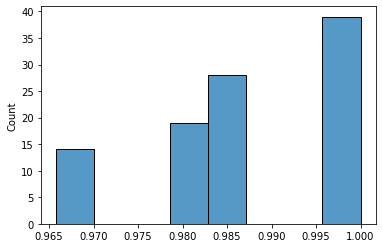

In [263]:
import seaborn as sns
sns.histplot([i[0] for i in test_accuracy_scores])

<AxesSubplot:ylabel='Count'>

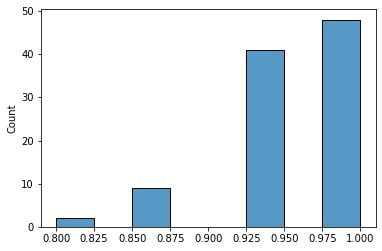

In [262]:
sns.histplot([i[1] for i in test_accuracy_scores])

In [156]:
import pickle

bootstrap_result_dict = {
    'model_tune_history': model_tune_history,
    'test_accuracy_scores': test_accuracy_scores,
    'features_list': features_list,
}
pickle.dump(bootstrap_result_dict, open('bootstrap_result_dict.p', 'wb'),
            pickle.HIGHEST_PROTOCOL)

### Summarize data

In [291]:
%%time

# store weights vector to dict
feature_weight_dict = {
    g: [0 for i in range(100)]
    for g in list(set().union(
        *list(map(lambda x: set(x.gene), features_list))))
}

for i, l in enumerate(features_list):
    for _, row in l.iterrows():
        feature_weight_dict[row['gene']][i] = row['coef']

CPU times: user 18.3 s, sys: 25.4 ms, total: 18.4 s
Wall time: 18.4 s


%%time
feature_count_dict={g:0 for g in list(set().union(*list(map(lambda x: set(x.gene),features_list))))}
feature_weight_dict= feature_count_dict.copy()

for l in features_list:
    for _, row in l.iterrows():       
        feature_count_dict[row['gene']]+=1
        feature_weight_dict[row['gene']]+=row['coef']
        

df_feature_genes = pd.DataFrame.from_dict(
    feature_count_dict.items()).rename(columns={
        0: 'gene',
        1: 'counts'
    }).set_index('gene').sort_values('counts', ascending=False)

df_feature_genes= df_feature_genes.join(
    pd.DataFrame.from_dict(feature_weight_dict.items()).rename(columns={
        0: 'gene',
        1: 'avg_weights'
    }).set_index('gene'))


# add std
df_feature_genes['weight_std'] = [
    np.std(feature_weight_dict[g]) * 100
    for g, _ in df_feature_genes.iterrows()
]
df_feature_genes.head()

In [373]:
df_feature_genes = pd.DataFrame({
    'gene': [g for g in feature_weight_dict.keys()],
    'counts': [np.sum(np.array(v) != 0) for v in feature_weight_dict.values()],
    'avg_weight': [np.sum(np.array(v)) for v in feature_weight_dict.values()],
    'std_weight':
    [np.std(np.array(v)) * 100 for v in feature_weight_dict.values()],
}).set_index('gene').sort_values('avg_weight', ascending=False)

In [376]:
df_feature_genes[df_feature_genes.counts>90].shape[0]

20

In [385]:
df_feature_genes[df_feature_genes.counts>90].sort_values('avg_weight')

,counts,avg_weight,std_weight
gene,,,
Adm,100,-0.120195,0.078230
Mbd1,98,-0.114090,0.077642
Il1a,97,-0.102954,0.056897
Wnk3,93,-0.097495,0.058660
Znfx1,93,-0.056522,0.031803
Fthl17a,94,-0.052886,0.032947
Cdk1,97,0.046450,0.023045
Birc5,99,0.047848,0.021984
Cdca3,98,0.048492,0.020873


In [384]:
df_feature_genes.to_csv('bootstrap_features.csv')
df_feature_genes[df_feature_genes.counts > 90].sort_values(
    'avg_weight', ascending=False).to_csv('bootstrap_features_selected.csv')